<a href="https://colab.research.google.com/github/halloikama/CA_troll_research/blob/master/ULMFit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai
!pip install git+https://github.com/NVIDIA/apex

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
  Cloning https://github.com/NVIDIA/apex to /tmp/pip-req-build-0237m9js
  Running command git clone -q https://github.com/NVIDIA/apex /tmp/pip-req-build-0237m9js
  Running command git submodule update --init --recursive -q
  Created wheel for apex: filename=apex-0.1-cp36-none-any.whl size=192130 sha256=dd89472373bcc1c19d779c77c09a220046a2d61dc626ca984a8be8cb55540a12
  Stored in directory: /tmp/pip-ephem-wheel-cache-u7docay3/wheels/91/1e/dc/41a5ba86547c578bd19be9cb9bdfd90b4e797acc58377e343b
Successfully built apex


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string 
import warnings 
import seaborn as sns 
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split


from fastai import *
from fastai.text import *
from pathlib import Path

import torch

%load_ext autoreload
%autoreload 2

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data_path = '/content/drive/My Drive/ULMfit/annotated_posts.json'
data = pd.read_json(data_path) 

In [8]:
data

,type,body,id,is_first_post,depth,author,reply_to
0,announcement,4/7/13 \n\n7/27/12 \n\nhttp://www.imdb.com/t...,t3_1bx6qw,1,0,DTX120,None
1,elaboration,I've wanted to watch this for a long time. I w...,t1_c9b2nyd,0,1,mcgrewf10,t3_1bx6qw
2,elaboration,You strike me as the type who would appreciate...,t1_c9b30i1,0,2,DTX120,t1_c9b2nyd
3,elaboration,"Yeah, I've always heard that Altman was famous...",t1_c9b6sj0,0,3,mcgrewf10,t1_c9b30i1
4,announcement,"Alright guys, little background about myself. ...",t3_omv7p,1,0,Keatonus,None
...,...,...,...,...,...,...,...
101434,question,Did anyone else spot the Floatzen 2 DVD?\nI kn...,t3_48toyo,1,0,Pradfanne,None
101435,answer,I didn't notice it until it was too late. What...,t1_d0mhap4,0,1,Portgas,t3_48toyo
101436,answer,"I don't know, it was to quick.\nI just liked t...",t1_d0n2wdx,0,2,Pradfanne,t1_d0mhap4
101437,answer,The Frozen parody was on the right edge of the...,t1_d0msypp,0,2,SaucyServine,t1_d0mhap4


In [9]:
df = pd.DataFrame({'label':data.type, 'text':data.body})
df_train, df_val = train_test_split(df, stratify = df['label'], test_size = 0.2, random_state = 12)
df_train

,label,text
41671,question,So I haven't played a properly challenging gam...
6711,agreement,The hive mind is quite real. I've discovered t...
32311,agreement,Ours too! My critter loves the Zeppelin album.
74989,agreement,That brand of headsets are really good! Top of...
82733,question,🙏
...,...,...
25373,answer,I posted a list of everything I have in anothe...
97088,answer,HH Scott was one of the top golden age tube br...
66725,negativereaction,You might be overreacting just a little bit
86444,elaboration,Use your inner asshole and put her in that big...


In [10]:
#tokenizing, numericalizing
data_lm = TextLMDataBunch.from_df(train_df = df_train, valid_df = df_val, path = "")

In [11]:
data_lm.show_batch()

idx,text
0,"and i get one - shotted off the bridge . \n \n xxmaj so i looked into tips , tried the ladder technique , got him 3 times , one more should do it ... pinned against foot of ladder when i jump off him , one shotted . \n xxmaj what am i doing wrong ? d : \n \n xxmaj also , if you die"
1,"fl so bad i kicked myself out of the group . \n \n xxmaj for those of you with a xxup gs of anything above 160 + , tips for a casual ? xxup iirc my xxup dps is 110k , xxup hp is xxunk & xxmaj electronics is xxunk . xxmaj rocking a grape xxup aug , blue xxmaj first xxmaj wave xxup m1a and the xxmaj damascus"
2,"or even make something . xxmaj you really do n't have to go extravagant unless you want to . i assumed $ 20 was enough for a nice gift . xxbos xxmaj interesting way of putting it , though i doubt he shares an understanding of numbers the way we see it . xxmaj thank you though ! xxbos i do n't think you have to pay to visit xxmaj"
3,", colors , window or not , xxup led lighting , etc ) , or a particular color theme preference for the components ? * * \n \n xxmaj no \n \n > * * xxmaj do you need a copy of xxmaj windows included in the budget ? xxmaj if you do need one included , do you have a preference ? * * \n \n"
4,"xxmaj try to use a low xxup iso and a 30 "" shutter but keeping your f as low as possible . xxmaj otherwise play with manual once you find the right ambient exposure . \n \n xxmaj without flash or strobe you wo n't arrest the motion of the xxunk , and using those is going to xxup ruin the experience for those around you . \n \n"


##Fine Tuning Language Model

In [10]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.7)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [11]:
from pynvml import *
nvmlInit()
try:
    deviceCount = nvmlDeviceGetCount()
    for i in range(deviceCount):
        handle = nvmlDeviceGetHandleByIndex(i)
        print("Device", i, ":", nvmlDeviceGetName(handle))
except NVMLError as error:
    print(error)

Device 0 : b'Tesla K80'


In [0]:
torch.cuda.set_device(0)

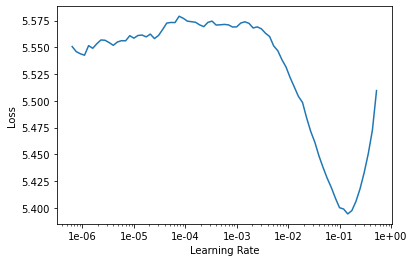

In [13]:
learn.recorder.plot(skip_end=15)

In [14]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.566181,4.256377,0.261382,13:04


In [20]:
#saving first fine-tuning
learn.save(file='/content/drive/My Drive/ULMfit/fit_head', return_path=True)

PosixPath('/content/drive/My Drive/ULMfit/fit_head.pth')

In [0]:
#continue fine-tuning
learn.load('/content/drive/My Drive/ULMfit/fit_head');

In [0]:
learn.unfreeze()

In [25]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.187956,4.134038,0.273970,14:56
1,4.151696,4.064797,0.283380,14:56
2,4.066146,4.020894,0.288656,14:57
3,3.971011,3.988448,0.292328,14:57
4,3.904855,3.969283,0.294580,14:58
5,3.753894,3.955678,0.296648,14:59
6,3.698991,3.950329,0.297719,14:57
7,3.639681,3.951724,0.297845,14:57
8,3.551716,3.953078,0.298069,14:58
9,3.557785,3.956047,0.298003,14:58


In [0]:
learn.save(file='/content/drive/My Drive/ULMfit/fine_tuned', return_path=True)
learn.save_encoder('/content/drive/My Drive/ULMfit/fine_tuned_enc')

In [0]:
 learn.load('/content/drive/My Drive/ULMfit/fine_tuned');

In [0]:
TEXT = "you are "
N_WORDS = 40
N_SENTENCES = 2

In [35]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

you are  a verified xxbos If you 're still in school , try and find a new home , even if you are n't prepared for a future . 
 
  If you do n't have a college degree , go
you are  probably gon na wreck her back with your situation . xxbos The next one is Robbie Rogers xxbos This is a very applicable solution to a problem with a MAC . You need to


##Classification

In [12]:
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_train, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

In [0]:
#data for QA classification (Question, Answer, Other)
df_train_QA = df_train.copy(deep=True)
df_test_QA = df_val.copy(deep=True)

In [0]:
df_train_QA['label'].mask((df_train_QA['label'] != 'question') & (df_train_QA['label'] != 'answer'), 'other', inplace=True)
df_test_QA['label'].mask((df_test_QA['label'] != 'question') & (df_test_QA['label'] != 'answer'), 'other', inplace=True)

In [15]:
data_class_QA = TextClasDataBunch.from_df(path = "", train_df = df_train_QA, valid_df = df_test_QA, vocab=data_lm.train_ds.vocab, bs=60)

In [16]:
data_clas.show_batch()

text,target
xxbos xxmaj source : https : / / www.bungie.net / en / xxmaj news / xxmaj article / xxunk \n \n --- \n \n * * 2.2.0 - xxmaj the xxmaj one about the xxmaj april xxmaj update . * * \n \n xxmaj oryx may have been defeated but many xxmaj taken remain and the denizens of the xxmaj reef are seeking revenge for their loss,announcement
"xxbos xxmaj happy xxmaj friday everyone :) i hope everyone has a great xxmaj easter weekend ! xxmaj selling and swapping only this week , unless its something on my wishlist i may consider buying . \n \n * * xxmaj if the items in the album are not listed below , it is no longer available ! xxmaj please make sure you double check to see if it",other
xxbos * * 2013 xxup lego xxmaj black xxmaj friday xxmaj promotions * * \n * xxup free xxmaj limited xxmaj edition xxmaj holiday xxmaj set with purchase of $ 99 or more \n * xxup free $ 10 xxmaj gift xxmaj card with purchase of $ 149 or more ( online only ) \n * xxup free xxmaj shipping on all orders ( no minimum ),announcement
"xxbos * * xxup tl;dr xxmaj we forget to appreciate . xxmaj we forget the gifts we have . xxmaj we may not realize it now , but it 's ruining our lives . i know this is a wall of text , but it might be worth a read - it 's written very simply . * * \n \n xxmaj my body is healthy . i have",announcement
"xxbos xxmaj you submitted this post as a text post , meaning clicking the title leads to this page . xxmaj you may want to edit the link into the post . \n \n xxmaj mineral oil does n't dissipate heat very well . xxmaj you 'll have a decent starting temperature , but it 'll slowly climb . xxmaj in a high end rig like this , you",elaboration


In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.6)
learn.load_encoder('/content/drive/My Drive/ULMfit/fine_tuned_enc');

In [43]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


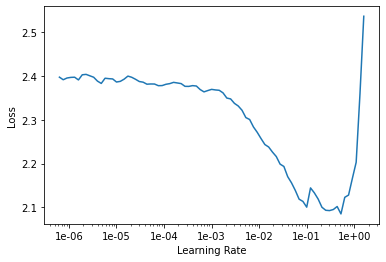

In [44]:
learn.recorder.plot()

In [45]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.341208,1.266910,0.560183,07:51


In [46]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.159836,1.074352,0.616571,09:53


In [47]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.074582,1.031569,0.632196,16:37


In [48]:


learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))



epoch,train_loss,valid_loss,accuracy,time
0,0.961287,1.011440,0.639984,18:20
1,0.940281,1.011580,0.635351,22:04


In [0]:
learn.save('/content/drive/My Drive/ULMfit/full-cd')


In [57]:
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis = 1)

In [0]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report


In [81]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
prediction = np.argmax(preds, axis=1)

In [82]:
prediction

tensor([2, 5, 2,  ..., 0, 2, 5])

In [84]:
print(classification_report(y, prediction))

              precision    recall  f1-score   support

           0       0.60      0.48      0.53       989
           1       0.46      0.36      0.41       393
           2       0.63      0.82      0.71      8076
           3       0.76      0.78      0.77      1700
           4       0.53      0.13      0.21       672
           5       0.45      0.33      0.38      3761
           6       0.24      0.16      0.19       472
           7       0.39      0.23      0.29       368
           8       0.41      0.16      0.23       396
           9       0.82      0.80      0.81      3461

    accuracy                           0.64     20288
   macro avg       0.53      0.43      0.45     20288
weighted avg       0.62      0.64      0.61     20288



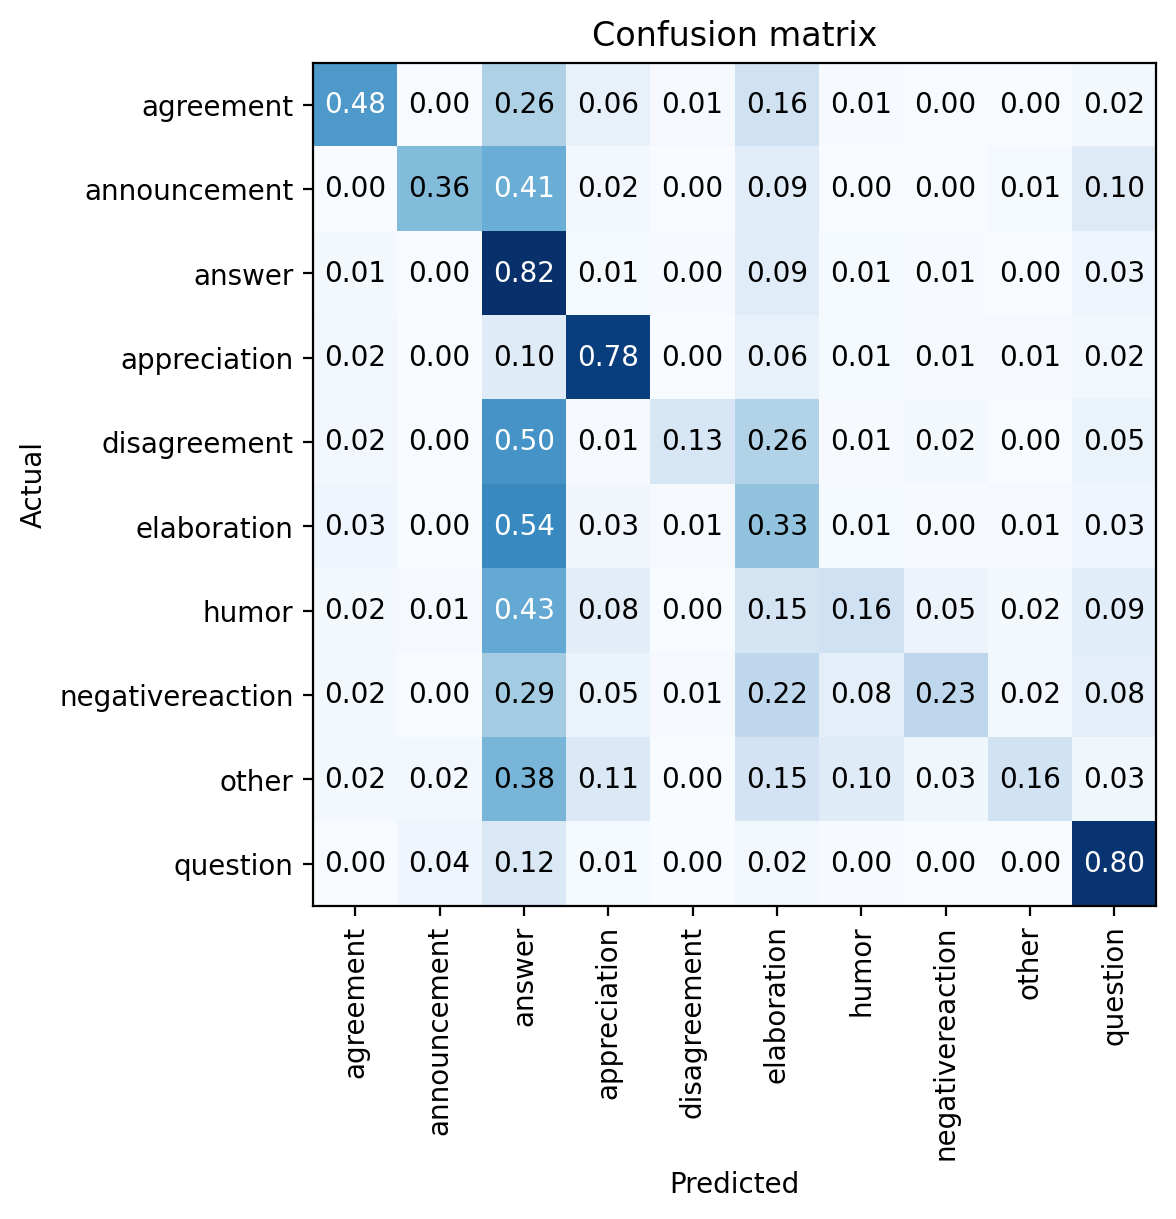

In [85]:
interp.plot_confusion_matrix(normalize=True, figsize=(6,6), dpi=200)

##QA classification

In [0]:
learn = text_classifier_learner(data_class_QA, AWD_LSTM, drop_mult=0.6)
learn.load_encoder('/content/drive/My Drive/ULMfit/fine_tuned_enc');

In [18]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


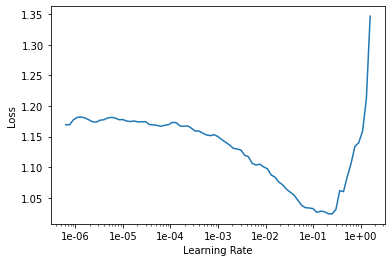

In [19]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.766936,0.711152,0.655757,06:34


In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))